In [1]:
!git clone https://github.com/JelleAalbers/flamedisx.git

fatal: destination path 'flamedisx' already exists and is not an empty directory.


In [2]:
# Install TF2 and TFP w GPU support (change runtime to GPU to test)
!pip install -U tensorflow-gpu==2.0.0
!pip install -U tensorflow_probability==0.8.0

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Requirement already up-to-date: tensorflow-gpu==2.0.0 in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: tensorflow_probability==0.8.0 in /usr/local/lib/python3.6/dist-packages (0.8.0)


In [3]:
tf.__version__, tfp.__version__, tf.test.is_gpu_available(), tf.executing_eagerly()

('2.0.0', '0.8.0', True, True)

In [4]:
%cd flamedisx
!git checkout master
!git pull origin master
!python setup.py develop
%cd ..

/content/flamedisx
Already on 'master'
Your branch is up to date with 'origin/master'.
From https://github.com/JelleAalbers/flamedisx
 * branch            master     -> FETCH_HEAD
Already up to date.
running develop
running egg_info
writing flamedisx.egg-info/PKG-INFO
writing dependency_links to flamedisx.egg-info/dependency_links.txt
writing requirements to flamedisx.egg-info/requires.txt
writing top-level names to flamedisx.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'flamedisx.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.6/dist-packages/flamedisx.egg-link (link to .)
flamedisx 0.1.2 is already the active version in easy-install.pth

Installed /content/flamedisx
Processing dependencies for flamedisx==0.1.2
Searching for tensorflow-probability==0.8.0
Best match: tensorflow-probability 0.8.0
Adding tensorflow-probability 0.8.0 to easy-install.pth file

Using /usr/local/lib/python3.6/dist-packages
Searching for tensorfl

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from multihist import Hist1d, Histdd

import flamedisx
import flamedisx as fd
from flamedisx.x1t_sr0 import SR0WIMPSource, SR0NRSource, SR0ERSource
import wimprates as wr
from wimprates import j2000
from scipy import stats, interpolate

# raise errors on any warning
#import warnings
#warnings.filterwarnings("error")

In [0]:
class VarLifetimeSource:
    time_min = pd.Timestamp(pd.to_datetime('2016-09-13T12:00:00')).value
    time_max = pd.Timestamp(pd.to_datetime('2017-09-13T12:00:00')).value
    
    def electron_detection_eff(self, drift_time, event_time, *, extraction_eff=1):
        #elife = 200e3 + (300e3 * (event_time - self.time_min)/(self.time_max - self.time_min))
        # FIXING ELIFE
        elife = 452e3
        return extraction_eff * tf.exp(-drift_time / elife)
    
class ModERSource(VarLifetimeSource, SR0ERSource):
    def random_truth(self, energies, fix_truth=None, **params):
        d = super().random_truth(energies, fix_truth=fix_truth, **params)

        d['x_observed'] = d['x']
        d['y_observed'] = d['y']
        return d

class ModNRSource(VarLifetimeSource, SR0NRSource):
    def random_truth(self, energies, fix_truth=None, **params):
        d = super().random_truth(energies, fix_truth=fix_truth, **params)

        d['x_observed'] = d['x']
        d['y_observed'] = d['y']
        return d

    #data_methods = tuple(list(SR0NRSource.data_methods) + ['p_electron_fluctuation'])
    #do_pel_fluct = True
    #@staticmethod
    #def p_electron_fluctuation(nq):
    #    # From SR0, BBF model, right?
    #    # q3 = 1.7 keV ~= 123 quanta
    #    return tf.clip_by_value(0.041 * (1. - tf.exp(-nq / 123.)),
    #                            1e-4,
    #                            float('inf'))

    #es = np.geomspace(1.0, 50, 100)

    ##t_start = pd.to_datetime('2016-09-13T12:00:00')
    ##t_stop = pd.to_datetime('2017-09-13T12:00:00')
    ##n_in = 2

    def _single_spectrum(self):
        return self.example_sp.bin_centers, self.example_sp.histogram
    def energy_spectrum(self, drift_time):
        n_evts = len(drift_time)
        return (fd.repeat(self.example_sp_centers, repeats=n_evts, axis=0),
                fd.repeat(self.example_sp_values, repeats=n_evts, axis=0))
    # Compute events/bin spectrum for a WIMP
    example_wimp_es = np.geomspace(0.7, 50, 100)
    example_wimp_rs = wr.rate_wimp_std(example_wimp_es,
                                       mw=1e3, sigma_nucleon=1e-45)
    example_sp = Hist1d.from_histogram(example_wimp_rs[:-1] * np.diff(example_wimp_es),
                                       example_wimp_es)
    example_sp_centers = tf.convert_to_tensor(example_sp.bin_centers[np.newaxis, :], dtype=fd.float_type())
    example_sp_values = tf.convert_to_tensor(example_sp.histogram[np.newaxis, :], dtype=fd.float_type())
        

dsets = dict(
    er=dict(source_class=ModERSource),
    nr=dict(source_class=ModNRSource))

for k, v in dsets.items():
    dsets[k]['source'] = v['source_class'](batch_size=200, max_sigma=6)

In [0]:
def annotate_cs(d):
    d['cs1'] = (0.142 / (1 + 0.219)) * d['s1'] / (
        d['photon_detection_eff'] * d['photon_gain_mean'])
    d['cs2'] = (11.4 / (1 - 0.63) / 0.96) * d['s2'] / (
        d['electron_detection_eff'] * d['electron_gain_mean'])

Eff improvements from:
  * Nonzero bin size messes with likelihood
  * Finite statistics messes 

100%|██████████| 100/100 [15:58<00:00,  9.64s/it]


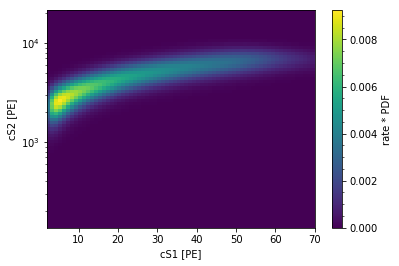

100%|██████████| 40/40 [06:12<00:00,  9.26s/it]


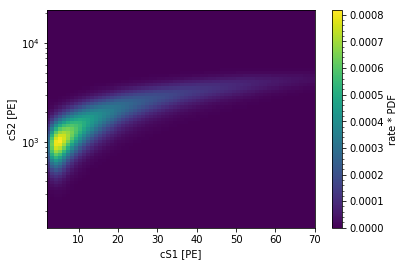

In [14]:
for dname, q in dsets.items():
    # Use same binning as SR1 results
    # (except adjusting for cS2b -> cS2)
    q['mh'] = mh = Histdd(bins=(np.linspace(2, 70, 68 + 1),
                                np.geomspace(10**1.7 / (1 - 0.63),
                                             10**3.9 / (1 - 0.63), 
                                             70)))
    
    # Actually 40 gives pretty good results already, but let's do it right
    # TODO RESTORE BATCHES
    n_batches = 100 if dname == 'er' else 40
    trials_per_batch = int(1e6)
    
    for _ in tqdm(range(n_batches)):
        d = q['source'].simulate(trials_per_batch)
        #d = q['source'].annotate_data(d)
        annotate_cs(d)
        mh.add(d['cs1'], d['cs2'])
    
    # Convert to PDF
    mh /= mh.bin_volumes() * trials_per_batch * n_batches

    # Multiply by total expected event rate
    # (from the source, i.e. before correcting for efficiencies)
    mh *= q['source'].mu_before_efficiencies()
    q['mh'] = mh

    plt.yscale('log')
    mh.plot(cblabel='rate * PDF')
    plt.xlabel("cS1 [PE]")
    plt.ylabel("cS2 [PE]")
    plt.show()

In [15]:
for dn in ['er', 'nr']:
    print(dsets[dn]['source'].mu_before_efficiencies())

1000.0
28.55564200401927


(0.0001, 1)

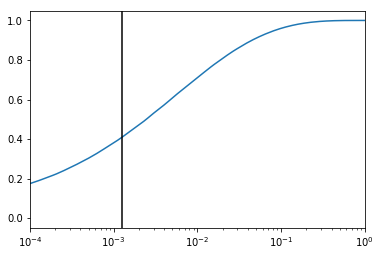

In [16]:
nr = dsets['nr']['mh'].histogram.ravel()
er = dsets['er']['mh'].histogram.ravel()

ins = np.argsort(er/(nr + 1e-9))
plt.figure()
plt.gcf().patch.set_facecolor('white')
plt.plot(np.cumsum(er[ins])/er.sum(),
         np.cumsum(nr[ins])/nr.sum())
plt.xscale('log')

plt.axvline(1/800, color='k')

plt.xlim(1e-4, 1)

In [0]:
#import pickle
#with open('dis')

In [0]:
for k, v in dsets.items():
    dsets[k]['source'] = v['source_class'](batch_size=100, max_sigma=6)

In [18]:
for dname, q in dsets.items():
    #ft_test = dict(x=0., y=0., z=-50,)
    q['data'] = d = q['source'].simulate(int(2e5))
    
    for _dn in dsets.keys():
        annotate_cs(d)
        
        # Ensure cs1 and cs2 are in range of the histogram, to avoid 
        # extrapolate in multihist's lookup.
        #
        # Bit sloppy to do this twice on the same data
        # but it is the same operation for ER and NR
        bes = q['mh'].bin_edges
        q['data'] = d = d[
            (bes[0][0] < d['cs1']) & (d['cs1'] < bes[0][-1]) &
            (bes[1][0] < d['cs2']) & (d['cs2'] < bes[1][-1])].copy()

        dsets[_dn]['source'].set_data(d)
        d['l_full_' + _dn] = dsets[_dn]['source'].batched_differential_rate()
        
        pdf_hist = dsets[_dn]['mh']  # actually diff rate hist
        
        d['l_mh_' + _dn] = pdf_hist.lookup(d['cs1'], d['cs2'])
        
    for lt in ('mh', 'full'):
        d['lr_' + lt] = d['l_%s_er' % lt] / d['l_%s_nr' % lt]

100%|██████████| 725/725 [03:04<00:00,  4.01it/s]


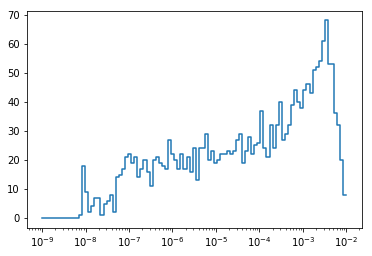

In [19]:
Hist1d(dsets['er']['mh'].histogram.ravel(), bins=np.geomspace(1e-9, 1e-2, 100)).plot()
plt.xscale('log')

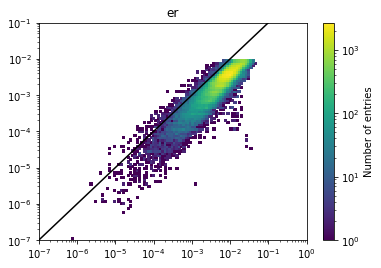

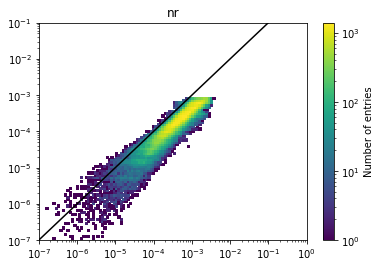

In [20]:
for dn in dsets:
    q = dsets[dn]['data']
    plt.figure()
    plt.gcf().patch.set_facecolor('white')
    #pdf_hist.plot()
    #plt.scatter(q['cs1'], q['cs2'], s=)
    Histdd(q['l_full_' + dn], q['l_mh_' + dn], bins=(np.geomspace(1e-7, 1e-1, 100),
                                                     np.geomspace(1e-7, 1e-1, 100))).plot(log_scale=True)
    plt.plot([1e-7, 1e-1], [1e-7, 1e-1], 'k-')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1e-7, 1e-1)
    plt.xlim(1e-7, 1)
    plt.title(dn)
    #plt.gca().set_aspect(1)
    plt.show()

In [21]:
dsets_data = dict()
for dn in ['er', 'nr']:
    dsets_data[dn] = dict()
    for k, v in dsets[dn].items():
        if k in ['source', 'source_class']:
            continue
        print(dn, k, type(v))
        dsets_data[dn][k] = v

er mh <class 'multihist.Histdd'>
er data <class 'pandas.core.frame.DataFrame'>
nr mh <class 'multihist.Histdd'>
nr data <class 'pandas.core.frame.DataFrame'>


In [0]:
import pickle
with open('discstudy_10oktober_elife452_2e5_final_maxsigma6_noposrec.pkl', mode='wb') as f:
    pickle.dump(dsets_data, f)

In [0]:
#with open('discstudy_10oktober_varelife.pkl', mode='rb') as f:
#    pickle.load(f)

In [0]:
def binom_interval(success, total, conf_level=0.95):
    """Confidence interval on binomial - using Jeffreys interval
    Code stolen from https://gist.github.com/paulgb/6627336
    Agrees with http://statpages.info/confint.html for binom_interval(1, 10)
    """
    # TODO: special case for success = 0 or = total? see wikipedia
    quantile = (1 - conf_level) / 2.
    lower = stats.beta.ppf(quantile, success, total - success + 1)
    upper = stats.beta.ppf(1 - quantile, success + 1, total - success)
    
    # If something went wrong with a limit calculation, report the trivial limit
    lower[np.isnan(lower)] = 0
    upper[np.isnan(upper)] = 1
    return lower, upper

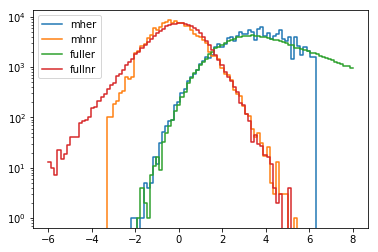

In [23]:
plt.figure()
plt.gcf().patch.set_facecolor('white')
for lt, color in [['mh', 'b'], ['full', 'g']]:
    hists = dict()
    cis = dict()
    for dname, q in dsets.items():
        exp = 20
        #if lt == 'mh':
        #    exp = 19
        hists[dname] = Hist1d(np.log10(q['data']['lr_' + lt].clip(10**-exp, 10**exp).values.astype('float')),
                              bins=np.linspace(-6, 8, 100))
        hists[dname].plot(label=lt + dname)
plt.yscale('log')
plt.legend()
plt.show()

mh: 0.00248 ER bg. at 50% NR acceptance
full: 0.0027 ER bg. at 50% NR acceptance


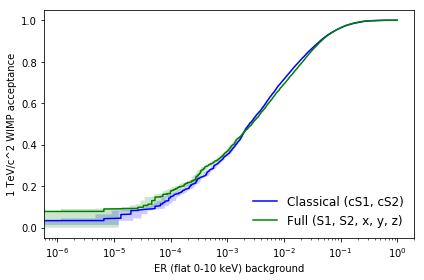

In [24]:
results = dict()

plt.figure()
plt.gcf().patch.set_facecolor('white')
for lt, color in [['mh', 'b'], ['full', 'g']]:
    hists = dict()
    cis = dict()
    for dname, q in dsets.items():
        hists[dname] = Hist1d(np.log10(q['data']['lr_' + lt].clip(1e-20, 1e20)),
                              bins=np.linspace(-20, 20, 10000))
        
        cis[dname] = binom_interval(
               np.cumsum(hists['er'].histogram),
               hists['er'].n, 
               conf_level=.68)
        
    x = np.cumsum(hists['er'].normalized_histogram)
    xlow, xhigh = cis['er'][0], cis['er'][1]
    y = np.cumsum(hists['nr'].normalized_histogram)
    
    results[lt] = dict(x=x, y=y, cis=cis, xlow=xlow, xhigh=xhigh, hists=hists)
    
    plt.plot(x, y,
             label=dict(mh="Classical (cS1, cS2)", 
                        full="Full (S1, S2, x, y, z)")[lt],
             color=color)
    
    print("%s: %0.3g ER bg. at 50%% NR acceptance" % (
        lt, x[np.argmin(np.abs(y - 0.5))]
    ))
    
    plt.fill_betweenx(
        y, cis['er'][0], cis['er'][1],
        color=color, alpha=0.2, linewidth=0, step='mid')
    
plt.legend(loc='lower right', frameon=False, fontsize=12)
    
plt.xscale('log')
plt.xlabel("ER (flat 0-10 keV) background")
plt.ylabel("1 TeV/c^2 WIMP acceptance")
#plt.xlim(1e-4, 1e-1)
#plt.xlim(0, 1)
#plt.ylim(0.95, 1)
plt.tight_layout()
#plt.savefig('ernr_disc_comp_varelife.png', bbox_inches="tight", dpi=200)
plt.show()

mh: 0.00545 ER bg. at 50% NR acceptance
full: 0.00387 ER bg. at 50% NR acceptance


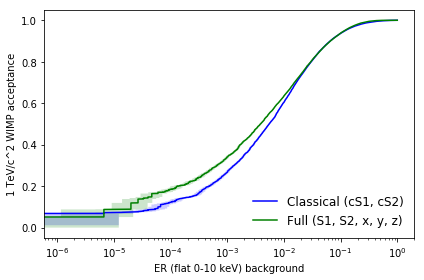

In [0]:
# 200 - 500 (2 - 70 pe, max sigma 6)

mh: 0.00555 ER bg. at 50% NR acceptance
full: 0.00391 ER bg. at 50% NR acceptance


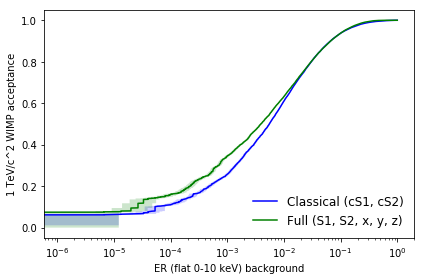

In [0]:
# 200 - 500 (2 - 70 pe)

mh: 0.00271 ER bg. at 50% NR acceptance
full: 0.00272 ER bg. at 50% NR acceptance


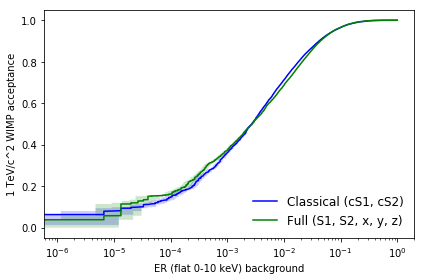

In [0]:
# 452 fixed (2 - 70 pe)

mh: 0.00918 ER bg. at 50% NR acceptance
full: 0.00605 ER bg. at 50% NR acceptance


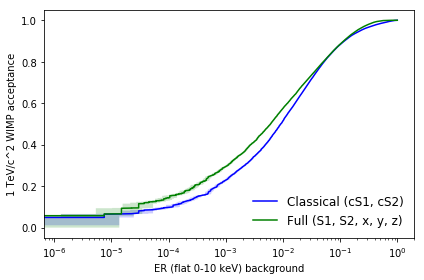

In [0]:
# 200 fixed (2 - 70 pe)

mh: 0.00857 ER bg. at 50% NR acceptance
full: 0.00489 ER bg. at 50% NR acceptance


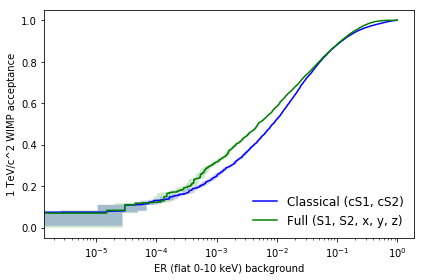

In [0]:
# 200 fixed

mh: 0.0027 ER bg. at 50% NR acceptance
full: 0.00257 ER bg. at 50% NR acceptance


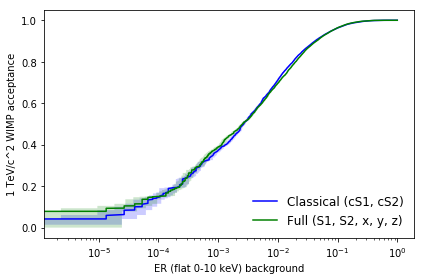

In [0]:
# 452 fixed

mh: 0.00539 ER bg. at 50% NR acceptance
full: 0.00421 ER bg. at 50% NR acceptance


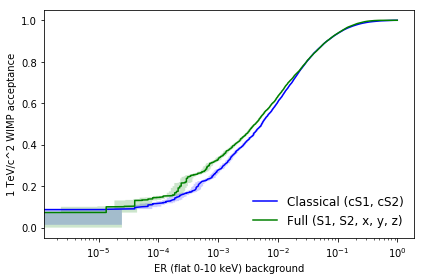

In [0]:
# 200 - 500 variable

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


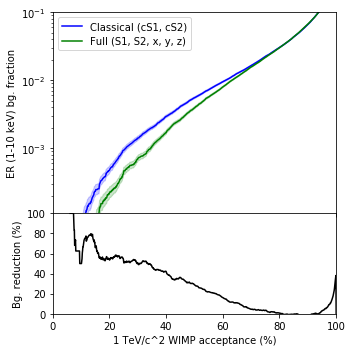

In [0]:
f, axes = plt.subplots(2, 1, 
                       figsize=(5, 5), 
                       gridspec_kw = {'height_ratios': [2, 1]},
                       sharex=True)
plt.gcf().patch.set_facecolor('white')

xscale = 100

for lt, color in [['mh', 'b'], ['full', 'g']]:
    q = results[lt]
    
    plt.sca(axes[0])
    plt.plot(q['y'] * xscale, q['x'],
             label=dict(mh="Classical (cS1, cS2)", 
                        full="Full (S1, S2, x, y, z)")[lt],
             color=color)
    plt.fill_between(
        q['y'] * xscale, q['xlow'], q['xhigh'],
        color=color, alpha=0.2)
    
def itp(x, xp, yp):
    return interpolate.interp1d(xp, yp, 
                                bounds_error=False, fill_value=(0,1))(x)
    
plt.sca(axes[1])
pts = np.linspace(0, 1, 1000)
r = {
    lt: {
        q: itp(pts, results[lt]['y'], results[lt]['x' + q])
          for q in ['', 'low', 'high']}
    for lt in results.keys()
}

plt.plot(pts * xscale, 
         100 * (r['mh']['']-r['full'][''])/r['mh'][''], c='k')

plt.ylabel("Bg. reduction (%)")
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.xlabel("1 TeV/c^2 WIMP acceptance (%)")

    
plt.sca(axes[0])
plt.yscale('log')
plt.ylim(1.1e-4, 1e-1)
plt.legend(loc='upper left')
plt.ylabel("ER (1-10 keV) bg. fraction")

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('ernr_disc_comp_varelife_2.png', bbox_inches="tight", dpi=200)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


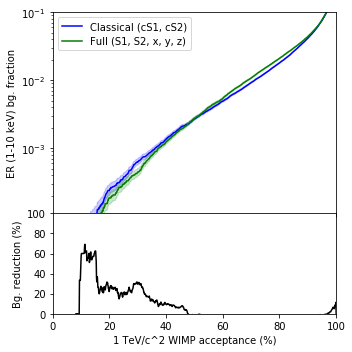

In [0]:
# 452 fixed (2 - 70 pe)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


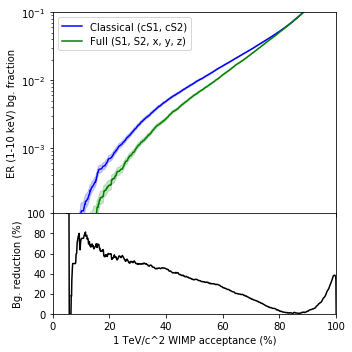

In [0]:
# 200 fixed (2 - 70 pe)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


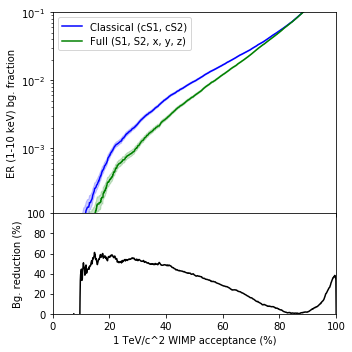

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


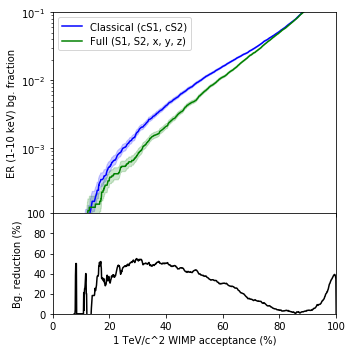

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


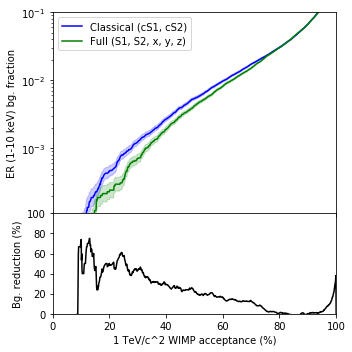

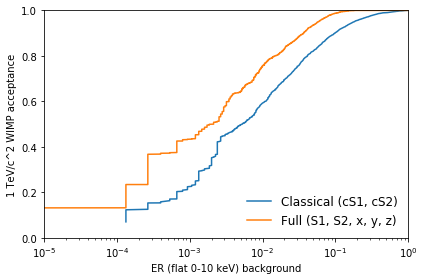

In [0]:
plt.figure()
plt.gcf().patch.set_facecolor('white')
for lt in ['mh', 'full']:
    hists = dict()
    for dname, q in dsets.items():
        hists[dname] = Hist1d(np.log10(q['data']['lr_' + lt].clip(1e-20, 1e20)),
                              bins=np.linspace(-20, 20, 50000))
    plt.plot(np.cumsum(hists['er'].normalized_histogram),
             np.cumsum(hists['nr'].normalized_histogram),
             label=dict(mh="Classical (cS1, cS2)", 
                        full="Full (S1, S2, x, y, z)")[lt])
    
plt.legend(loc='lower right', frameon=False, fontsize=12)
    
plt.xscale('log')
plt.xlabel("ER (flat 0-10 keV) background")
plt.ylabel("1 TeV/c^2 WIMP acceptance")
plt.xlim(1e-5, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('ernr_disc_comp.png', bbox_inches="tight", dpi=200)
plt.show()

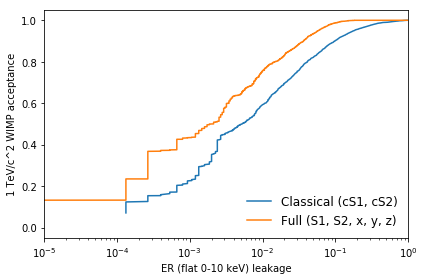

In [0]:
plt.figure()
plt.gcf().patch.set_facecolor('white')
for lt in ['mh', 'full']:
    hists = dict()
    for dname, q in dsets.items():
        hists[dname] = Hist1d(np.log10(q['data']['lr_' + lt].clip(1e-20, 1e20)),
                              bins=np.linspace(-20, 20, 50000))
    plt.plot(np.cumsum(hists['er'].normalized_histogram),
             np.cumsum(hists['nr'].normalized_histogram),
             label=dict(mh="Classical (cS1, cS2)", full="Full (S1, S2, x, y, z)")[lt])
    
plt.legend(loc='lower right', frameon=False, fontsize=12)
    
plt.xscale('log')
plt.xlabel("ER (flat 0-10 keV) leakage")
plt.ylabel("1 TeV/c^2 WIMP acceptance")
plt.xlim(1e-5, 1)
plt.tight_layout()
plt.savefig('disc_eff.png', bbox_inches="tight")
plt.show()

Run comb: just concat datasets, make model time-dependent, or better yet, dependent on what actualy causes difs (eg field)

Disdadv: 
 - slower than lookup/interpolation (even with freezing/GPUs), so quick sensi study without fitting NPs might take longer.
 - Generation model not infinitely flexible. Can't add e.g. depedence of photon eff on energy (but can add photon eff on number of photons)

/home/jelle/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


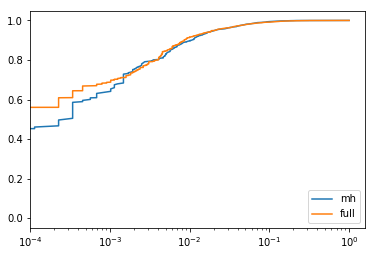

/home/jelle/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


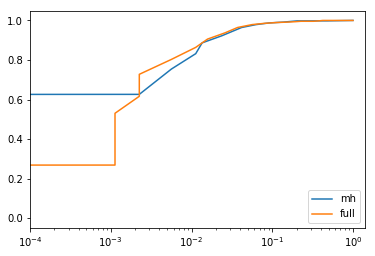

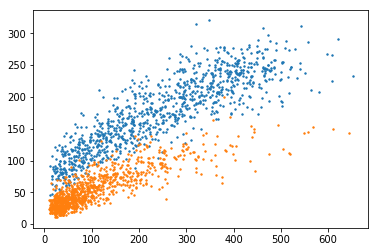

In [0]:
for dname, q in dsets.items():
    d = q['data'].sample(1000)
    plt.scatter(d['photon_detected_mle']/d['photon_detection_eff'],
                d['electron_detected_mle']/d['electron_detection_eff'],
                s=2)